# jupyter: import danych z drugiego zestawu

Dane w „drugim zestawie” są trochę inne. Jest to plik csv, gdzie wartości oddzielone są średnikiem, zawierający trzy kolumny: 
* timestamp
* czas w postaci „czytelnej”
* mierzona wartość
Informacje poprzedzone są czterolinikowym nagłówkiem — w pierwszej chwili zupełnie nieistotnym.

Do importu ponownie użyjemy funkcji [`genfromtxt`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) z pakietu `numpy`.

Ponieważ zawartość drugiej kolumny nie jest „zrozumiała” dla funkcji — wstawia ona tam wartości NaN.

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
plt.rcParams["figure.figsize"] = (12,9) # Tu definiujemy rozmiary wykresu. 
# Standardowo wydaje się być zbyt mały.

In [2]:
dane=np.genfromtxt('Outdoor_temperature_2017-09.csv',skip_header=4,delimiter=';')

Zacznijmy od szybkiego obejrzenia danych

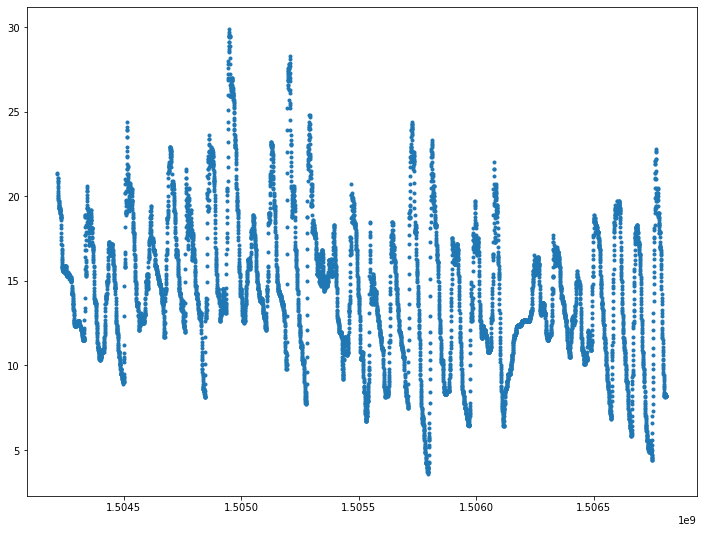

In [3]:
plt.plot(dane[:,0], dane[:,2], '.')
plt.show()

Współrzędna $x$ to (najprawdopodobniej) unixowy timestamp — można zastosować rozwiazanie sprawdzone wcześniej.

In [4]:
dates=[dt.datetime.fromtimestamp(ts) for ts in dane[:,0]]

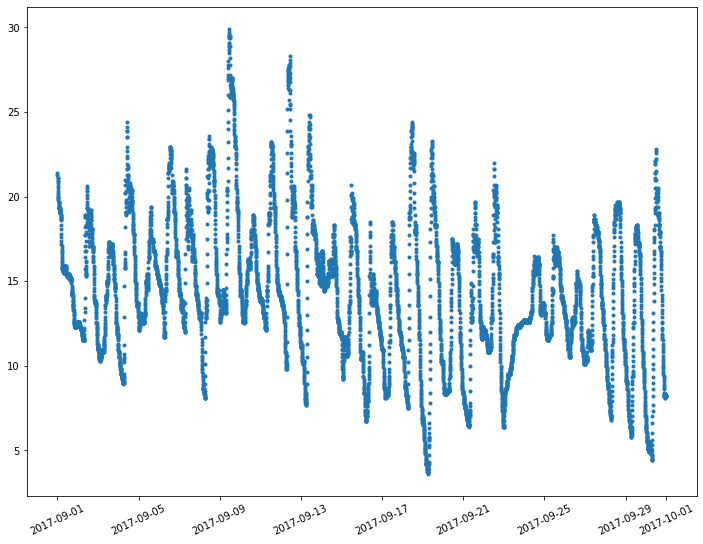

In [5]:
plt.xticks( rotation=25 )
ax = plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, dane[:,2], '.')
plt.show()

In [6]:
min(dates)

datetime.datetime(2017, 9, 1, 0, 2, 56)

In [7]:
min(dane[:,0])

1504216976.0

In [ ]:
plt.plot(dane[:,0] - min(dane[:,0]), dane[:,2], '.')
plt.show()

## Transformata Fouriera dla temperatur z miesiąca

Chcąc zbadać na ile zmiany temperaturu w ciągu miesiąca są okresowe można spróbować wyznaczyć transformatę Fouriera i zbadać dominującą składową.

Niestety związane jest to z wielu problemami. 
1. Danych jest bardzo dużo. Dużo za dużo!
2. Nie są one próbkowane ze stałym krokiem (a żeby FFT miało sens musi tak być).
3. Teoretycznie nie powinno to w niczym przeszkadzać, gdyż możemy dostaryczyć współrzędne $x$ i $y$ punktów, ale żadna znana mi implementacja FFT nie chce wartości współrzędnej $x$!

W naszym przypadku mamy tyle punktów danych:

In [8]:
dane.shape[0]

8565

Pochodzą one z jednego miesiaca (w przykładzie września), który ma 30 dni czyli

In [9]:
30 * 24 * 60 * 60/dane.shape[0]

302.62697022767077

były wykonywane średnio co około 5 minut (303 sekundy). Wydaje się, że pomiary co godzinę (albo nawet i dwie) wystarczą do naszej analizy. Teoretycznie możnaby wyrzucić wszystkie wartości pośrednie i dobrać pomiary z, mniej-więcej, całych godzin. Lepiej jednak użyć **interpolacji**.

Co więcej, zwracam uwagę, że nie interesuje nas czas **bezwzględny** tylko raczej względny gdzie pierwszy pomiar wykonany został w chwili zero, kolejny w sekundzie 3600 (po godzinie) i tak dalej. 

Stworzymy nową tablicę zawierającą wartości [0, 3600, 7200,…] obejmującą cały interesujjący nas zakres (miesiąc).

`min(dane[:,0])` to minimalny indeks czasowy danych, a `max(dane[:,0])` to maksymalny indeks czasowy

In [10]:
zakres=max(dane[:,0]) - min(dane[:,0])

Funkcja [`np.arange()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.arange.html) tworzy tablicę danych z zadanym krokiem obejmującą swoim zakresem analizowany mmiesiąc.

In [11]:
czas=np.arange(0, zakres, 7200)

Funkcja [`np.interp()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.interp.html) na podstawie danych wylicza dla całego wektora `czas` wartości funkcji (używając interpolacji liniowej) jeżeli to niezbędne.

In [12]:
temperatura = np.interp(czas, dane[:,0] - min(dane[:,0]), dane[:,2])

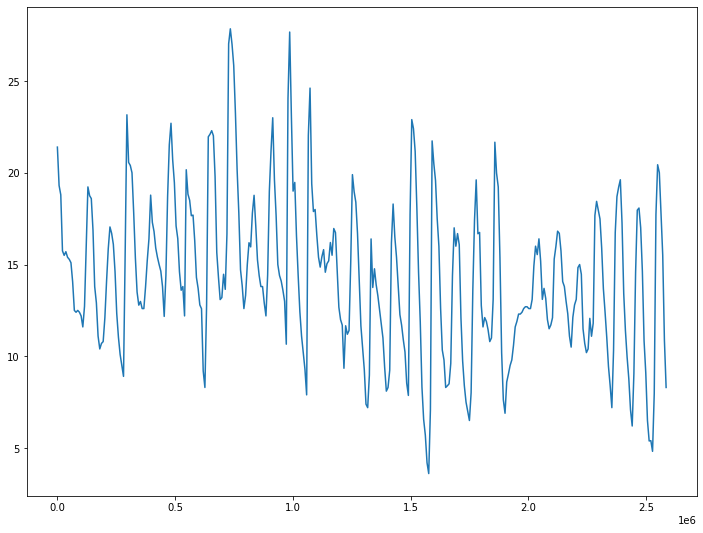

In [13]:
plt.plot(czas,temperatura)
plt.show()

In [14]:
czas.shape

(360,)

Operacja zmiany odstępu czasu pomiędzy próbkami nazywana jest _resamplingiem._ Przy czym, jeżeli częstość pomiarów zwiększamy — jest tu _upsampling,_ a gdy zmniejszamy — _downsampling._

Gdy pomiary są już dokonane ze stałym krokiem do down- i up-samplingu można wykorzystać interpolację trygonometryczną (realizowaną z użyciem FFT). Gdy pomiary — tak jak w tym przypadku — wykonywane są nieregularnie — pozostaje interpolacja.